# Health Insurance Cross Sell Prediction

### Business background
##### Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from the past year will also be interested in Vehicle Insurance provided by the company.
##### Meanwhile, building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimize its business model and revenue.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder,OrdinalEncoder
from category_encoders import TargetEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Deep Learning
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

## Load Data

In [3]:
df = pd.read_csv('train.csv')
df = df.set_index('id')

In [4]:
df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0


## EDA

In [5]:
profile = ProfileReport(df, title="Insurance Report", explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Get basic information about the dataset
# (like shape, data type, missing values, duplicates,etc.)
print(f'The dataset has {df.shape[0]} rows, and {df.shape[1]} columns \n')
df.info()

The dataset has 381109 rows, and 11 columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 43.0+ MB


In [7]:
# It seams this dataset contains numerical and categorical data types,
# need to convert to expected format later
# Now check the missing value and duplicates.
df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

###### There is no missing values

In [8]:
print(df.duplicated().sum())
print(f'This dataset has {df.duplicated().sum() / df.shape[0] * 100}% of duplicates')

269
This dataset has 0.0705834813662233% of duplicates


In [9]:
# Since it only has less than 0.1% of duplicates, so we just drop them
df.drop_duplicates(inplace=True)
df.shape

(380840, 11)

In [10]:
df['Response'].value_counts(normalize=True)

0    0.877416
1    0.122584
Name: Response, dtype: float64

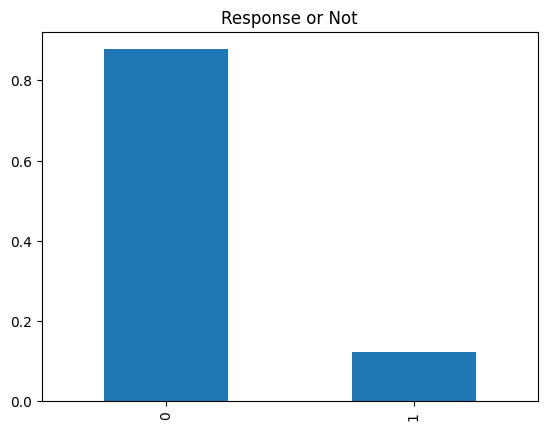

In [11]:
# First let see the target label
df['Response'].value_counts(normalize=True).plot(kind = 'bar')
plt.title('Response or Not');

In [12]:
# We can see from above the target data is imbalanced, so we need to implement random sampling or SMOT later.

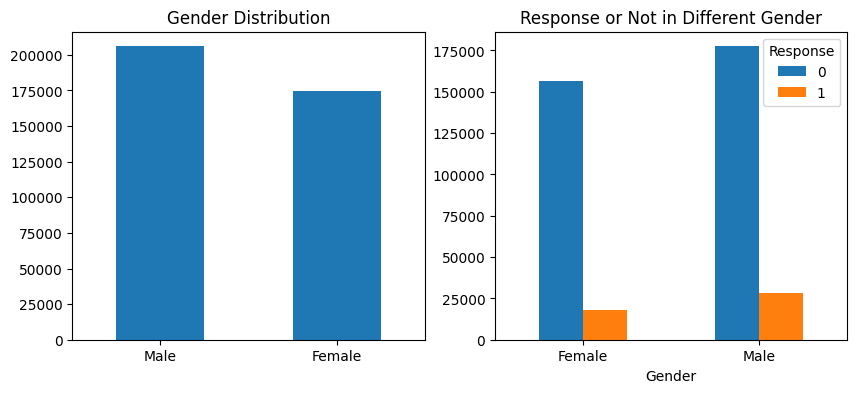

In [13]:
# Now we explore and analyze correlations between targer and other columns
# The relation between gender and response
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
df['Gender'].value_counts().plot(kind='bar',ax=axes[0])
axes[0].set_title('Gender Distribution')
axes[0].set_xticklabels(['Male', 'Female'], rotation=0)
df.groupby(['Gender','Response'])['Response'].count().unstack().plot(kind='bar',ax = axes[1])
axes[1].set_title('Response or Not in Different Gender')
plt.xticks(rotation=0);

In [14]:
# More males are willing to purchase a vehicle insurance than females

In [15]:
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [16]:
plot_cols = ['Driving_License','Previously_Insured','Vehicle_Damage','Vehicle_Age']

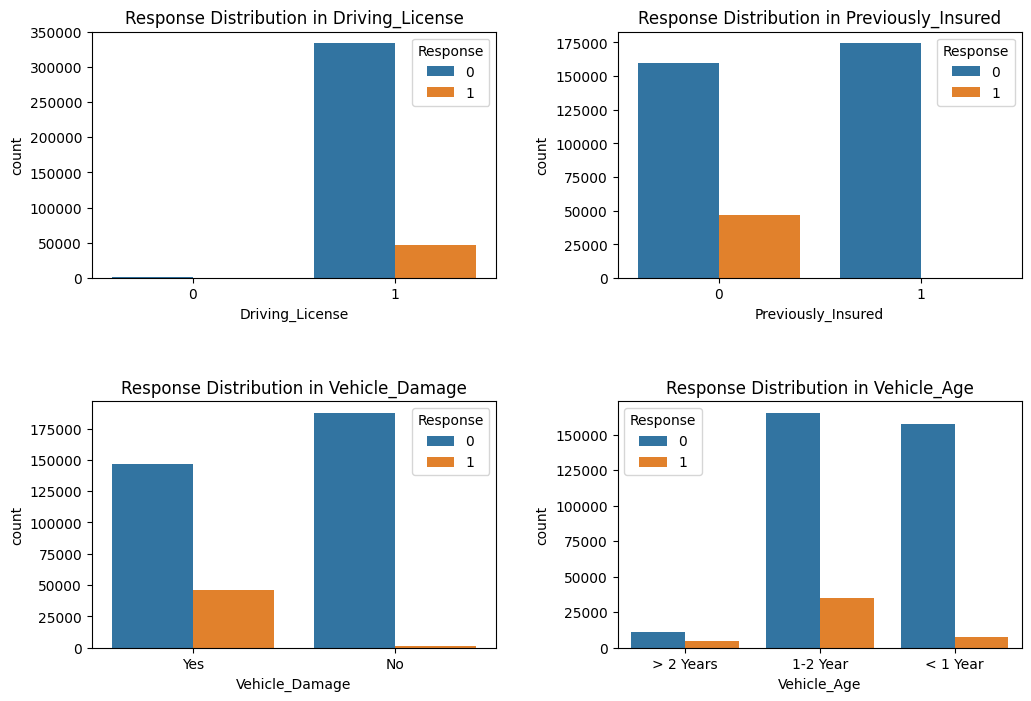

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i,j in enumerate(axes.flatten()):
    sns.countplot(x=plot_cols[i], hue = 'Response',\
                  data = df[[plot_cols[i],'Response']],ax=j)
    j.set_title(f'Response Distribution in {plot_cols[i]}');

In [18]:
# From the above plots, we can see that when people has driving license,
# the vehicle has damaged before or have previously insured then more likly willing to get insured
# However, more interesting is that almost each record in the dataset has driving license
# We are considering to drop this feature later, because it doesn't impact the result at high lever.

In [19]:
# Do the similar exploration for numerical columns
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000
mean,38.823593,0.997868,26.388307,0.458208,30584.016078,112.030225,154.344607,0.122584
std,15.513206,0.046126,13.229907,0.498251,17203.258664,54.206194,83.670240,0.327960
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24426.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31678.500000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


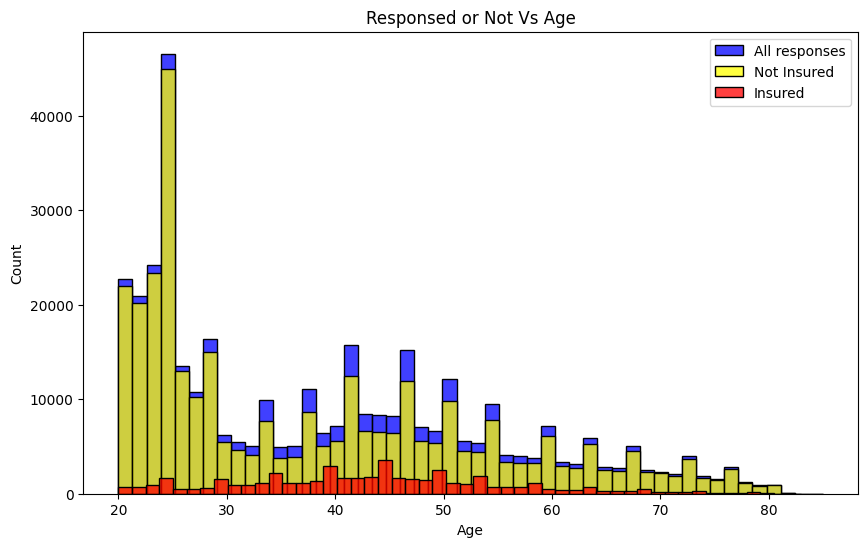

In [20]:
# Plot a hist to show people distribution among different ages in different response types
plt.figure(figsize=(10,6))
sns.histplot(x=df['Age'],color='blue',bins=50,label='All responses')
sns.histplot(df.Age[df.Response==0],bins = 50,color='yellow',label='Not Insured')
sns.histplot(df.Age[df.Response==1],bins = 50,color='red',label='Insured')
plt.title('Responsed or Not Vs Age')
plt.legend();

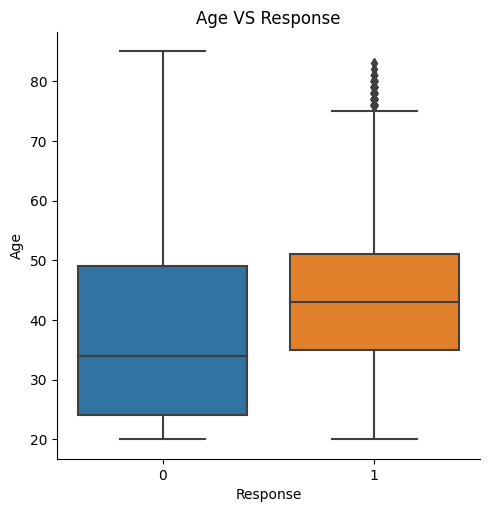

In [21]:
# Plot boxplot to check outliers
sns.catplot(x="Response",y="Age", data=df[['Age','Response']], kind='box')
plt.title("Age VS Response");

In [22]:
# We can see from above, for people aged between 20-30 are willing to NOT purchase an insurance,
# While, for age in range 40 - 50 who are more willing to purchase an insurance.
# Means age is an important feature to predict the target label

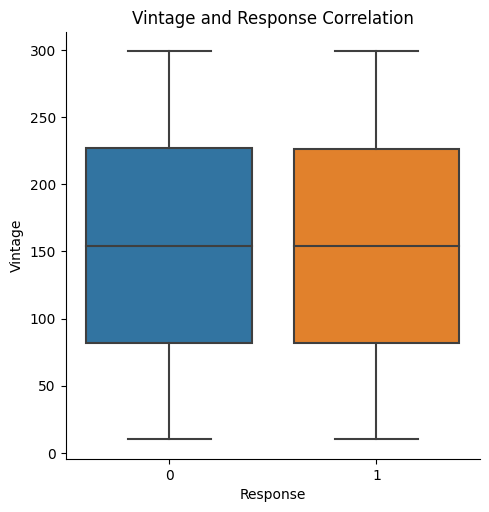

In [23]:
# See Vintage and Response correlation
sns.catplot(x="Response", y="Vintage", data=df[['Vintage','Response']], kind="box")
plt.title("Vintage and Response Correlation");

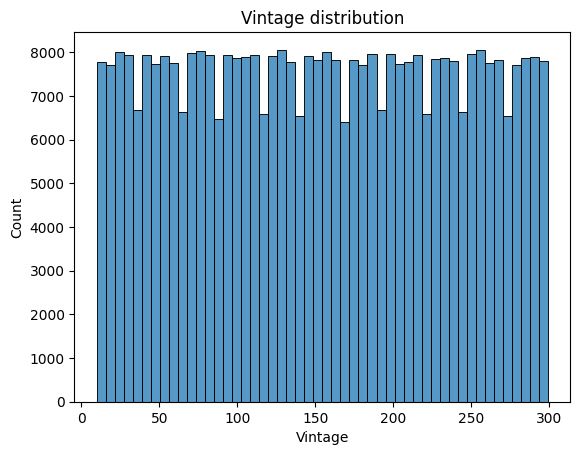

In [21]:
sns.histplot(df['Vintage'],bins=50)
plt.title('Vintage distribution');

Vintages stands for number of Days for a customer since associated with the company.The distribution of response among different vintages means quite silimar, which signifies no significate effect to the response.

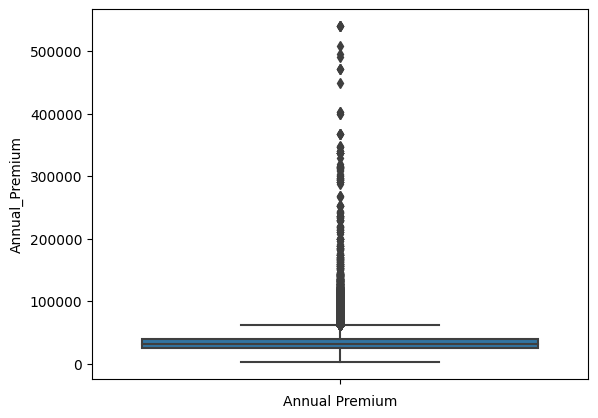

In [24]:
# Last check the Annual_Premium column
# See outliers using boxplot
sns.boxplot(y=df["Annual_Premium"])
plt.xlabel("Annual Premium");

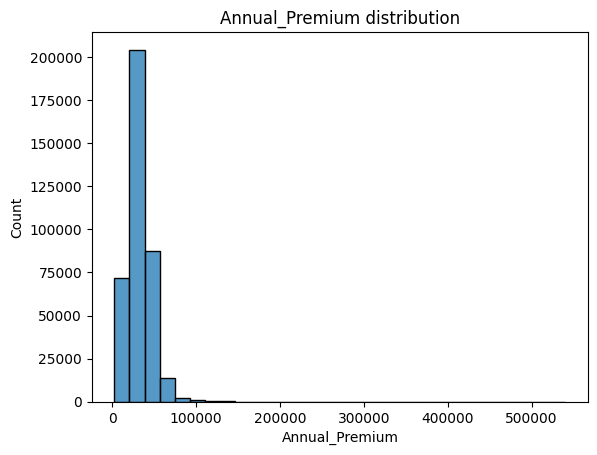

In [25]:
sns.histplot(x = df["Annual_Premium"],bins = 30)
plt.title('Annual_Premium distribution');

From above, it seams it exists outliers and highly skewed, need to clean it later

In [26]:
# Region_code column has the numerical data type,
# however it's more logical to convert to categorical later
# Maybe we could try bin? or some encoding techniques?
df['Region_Code'].unique()

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.,  8., 36., 30.,
       26., 16., 47., 48., 19., 39., 23., 37.,  5., 17.,  2.,  7., 29.,
       46., 27., 25., 13., 18., 20., 49., 22., 44.,  0.,  9., 31., 12.,
       34., 21., 10., 14., 38., 24., 40., 43., 32.,  4., 51., 42.,  1.,
       52.])

In [27]:
# Same scenario for Policy_Sales_Channel, bin or other encoding?
df['Policy_Sales_Channel'].unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

## Baseline Model

In [28]:
# For a binary classification problem, 
# normally logisticregression is a goog benchmark in the industry

In [29]:
X = df.drop(['Response'],axis = 1)
y = df['Response']

In [30]:
# Use SMOT to handle imbalanced dataset
X = pd.get_dummies(X,drop_first=True)

In [31]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
# Random over sampling using SMOTE
smt = SMOTE(random_state=42)
X_train,y_train = smt.fit_resample(X_train,y_train)

In [33]:
y_train.value_counts()

0    233813
1    233813
Name: Response, dtype: int64

In [34]:
X_train.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,53,1,28.0,0,40255.0,124.0,91,1,0,0,1
1,51,1,28.0,0,26752.0,26.0,99,0,0,0,1
2,25,1,41.0,0,33128.0,152.0,144,0,1,0,0
3,46,1,39.0,0,23592.0,42.0,61,1,0,0,1
4,61,1,14.0,0,2630.0,124.0,273,0,0,0,1


In [35]:
# Build the baseline model
base_model = LogisticRegression(random_state=42)

base_model.fit(X_train,y_train)
y_predict = base_model.predict(X_test)

print(classification_report(y_test,y_predict))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_predict)}')

              precision    recall  f1-score   support

           0       0.95      0.69      0.80    100342
           1       0.25      0.75      0.37     13910

    accuracy                           0.70    114252
   macro avg       0.60      0.72      0.59    114252
weighted avg       0.87      0.70      0.75    114252

AUC-ROC score is 0.7179774072743109


## Data Preprocessing & Feature Engineering

In [36]:
# Define a function to detect outliers and replace them with upper or lower values
def Outlier_Remove(col):
    q1 = np.percentile(df[col],25,method = 'midpoint')
    q3 = np.percentile(df[col],75,method = 'midpoint')
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return np.clip(df[col],lower,upper)

In [37]:
df['AP_Cleaned'] = Outlier_Remove('Annual_Premium')

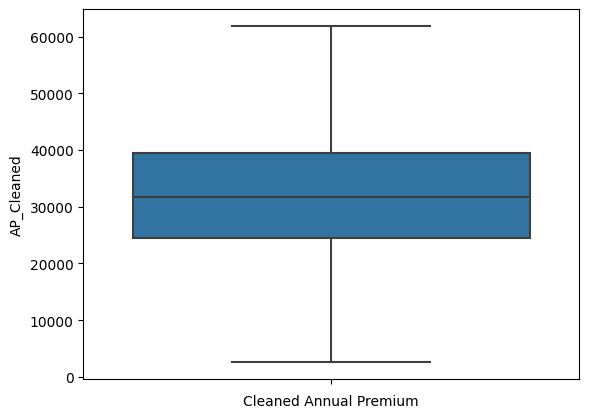

In [38]:
# Using boxplot to check again
sns.boxplot(y=df["AP_Cleaned"])
plt.xlabel('Cleaned Annual Premium');

In [39]:
df['AP_Cleaned'].describe()

count    380840.000000
mean      30167.190085
std       15463.979030
min        2630.000000
25%       24426.000000
50%       31678.500000
75%       39408.000000
max       61881.000000
Name: AP_Cleaned, dtype: float64

In [40]:
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'AP_Cleaned'],
      dtype='object')

In [41]:
# Drop unnecessary columns
data = df.drop(['Annual_Premium','Vintage','Driving_License'],axis=1)

# data = df.drop(['Response','Annual_Premium'],axis=1)

In [226]:
data.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response,AP_Cleaned
id,,,,,,,,,
1,Male,44,28.0,0,> 2 Years,Yes,26.0,1,40454.0
2,Male,76,3.0,0,1-2 Year,No,26.0,0,33536.0
3,Male,47,28.0,0,> 2 Years,Yes,26.0,1,38294.0
4,Male,21,11.0,1,< 1 Year,No,152.0,0,28619.0
5,Female,29,41.0,1,< 1 Year,No,152.0,0,27496.0


In [42]:
# Check data type again, and classify to categorical and numerical 
# First need to convert some data to the desired data type
# define a function to convert type
def type_convert(col,toType):
    if data[col].dtype != toType:
        data[col] = data[col].astype(toType)
    return

In [43]:
# Define columns need to convert type
# convert_cols = ['Region_Code','Previously_Insured','Policy_Sales_Channel','Driving_License']
convert_cols = ['Region_Code','Previously_Insured','Policy_Sales_Channel']
for i in convert_cols:
    type_convert(i,object)

In [44]:
# Check results
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380840 entries, 1 to 381109
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                380840 non-null  object 
 1   Age                   380840 non-null  int64  
 2   Region_Code           380840 non-null  object 
 3   Previously_Insured    380840 non-null  object 
 4   Vehicle_Age           380840 non-null  object 
 5   Vehicle_Damage        380840 non-null  object 
 6   Policy_Sales_Channel  380840 non-null  object 
 7   Response              380840 non-null  int64  
 8   AP_Cleaned            380840 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 29.1+ MB


In [45]:
# Set bins for Region_Dict and Policy_Sales_Channel
Region_Dict = {}
for i,j in list(zip(data['Region_Code'].value_counts().index.unique(),data['Region_Code'].value_counts(1)*100)):
    if j < 2: # Since majority unique region code are below 2%
        Region_Dict[i] = "Others"
    else:
        Region_Dict[i] = "Region_" + str(i)

In [48]:
# Same for the policy column
Policy_Sales_Channel_Dict = {}
for i,j in list(zip(data['Policy_Sales_Channel'].value_counts().index.unique(),data['Policy_Sales_Channel'].value_counts(1)*100)):
    if j < 2:
        Policy_Sales_Channel_Dict[i] = "Others"
    else:
        Policy_Sales_Channel_Dict[i] = "Channel_" + str(i)

In [49]:
# Apply the above result to the dataset
data['Region_Code'] = data['Region_Code'].map(Region_Dict)
data['Policy_Sales_Channel'] = data['Policy_Sales_Channel'].map(Policy_Sales_Channel_Dict)

In [50]:
data.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response,AP_Cleaned
id,,,,,,,,,
1,Male,44,Region_28.0,0,> 2 Years,Yes,Channel_26.0,1,40454.0
2,Male,76,Region_3.0,0,1-2 Year,No,Channel_26.0,0,33536.0
3,Male,47,Region_28.0,0,> 2 Years,Yes,Channel_26.0,1,38294.0
4,Male,21,Region_11.0,1,< 1 Year,No,Channel_152.0,0,28619.0
5,Female,29,Region_41.0,1,< 1 Year,No,Channel_152.0,0,27496.0


### One hot coding

In [51]:
# Define columns that need to one-hot encoding
# oh_cols = ['Gender','Vehicle_Damage','Driving_License','Region_Code','Previously_Insured','Policy_Sales_Channel']
oh_cols = ['Gender','Vehicle_Damage','Region_Code','Previously_Insured','Vehicle_Age','Policy_Sales_Channel']
temp_oh = pd.get_dummies(data[oh_cols],drop_first=True)
data = data.drop(oh_cols,axis=1).join(temp_oh)

In [52]:
data.columns

Index(['Age', 'Response', 'AP_Cleaned', 'Gender_Male', 'Vehicle_Damage_Yes',
       'Region_Code_Region_11.0', 'Region_Code_Region_15.0',
       'Region_Code_Region_28.0', 'Region_Code_Region_29.0',
       'Region_Code_Region_3.0', 'Region_Code_Region_30.0',
       'Region_Code_Region_33.0', 'Region_Code_Region_36.0',
       'Region_Code_Region_41.0', 'Region_Code_Region_46.0',
       'Region_Code_Region_50.0', 'Region_Code_Region_8.0',
       'Previously_Insured_1', 'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years',
       'Policy_Sales_Channel_Channel_124.0',
       'Policy_Sales_Channel_Channel_152.0',
       'Policy_Sales_Channel_Channel_156.0',
       'Policy_Sales_Channel_Channel_160.0',
       'Policy_Sales_Channel_Channel_26.0', 'Policy_Sales_Channel_Others'],
      dtype='object')

In [53]:
# # Set up bins for Age column
# # The min and max value for age is 20 and 80, so we decided to use .qcut function to set bins
# # we decide to set 4 bins
# q_boundaries = [20, 30, 40,50, 60, 70,80]
# q_labels = ['20-30_ages', '30-40_ages', '40-50_ages', '50-60_ages','60-70_ages', '70-80_ages']
# data['Age_bins'] = pd.cut(df['Age'], bins = q_boundaries, labels=q_labels)

# # Use one-hot again to encoding
# temp_bins = pd.get_dummies(data['Age_bins'])
# data = data.drop(['Age','Age_bins'],axis=1).join(temp_bins)

In [54]:
data

,Age,Response,AP_Cleaned,Gender_Male,Vehicle_Damage_Yes,Region_Code_Region_11.0,Region_Code_Region_15.0,Region_Code_Region_28.0,Region_Code_Region_29.0,Region_Code_Region_3.0,...,Region_Code_Region_8.0,Previously_Insured_1,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Policy_Sales_Channel_Channel_124.0,Policy_Sales_Channel_Channel_152.0,Policy_Sales_Channel_Channel_156.0,Policy_Sales_Channel_Channel_160.0,Policy_Sales_Channel_Channel_26.0,Policy_Sales_Channel_Others
id,,,,,,,,,,,,,,,,,,,,,
1,44,1,40454.0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,76,0,33536.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,47,1,38294.0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,21,0,28619.0,1,0,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
5,29,0,27496.0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381105,74,0,30170.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
381106,30,0,40016.0,1,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
381107,21,0,35118.0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


In [55]:
X = data.drop('Response',axis=1)
y = data['Response']

In [56]:
# Now split the dataset before scaling and transforming to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [57]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((266588, 25), (266588,), (114252, 25), (114252,))

### Target & Ordinal Encoding

In [58]:
X_train.head()

,Age,AP_Cleaned,Gender_Male,Vehicle_Damage_Yes,Region_Code_Region_11.0,Region_Code_Region_15.0,Region_Code_Region_28.0,Region_Code_Region_29.0,Region_Code_Region_3.0,Region_Code_Region_30.0,...,Region_Code_Region_8.0,Previously_Insured_1,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Policy_Sales_Channel_Channel_124.0,Policy_Sales_Channel_Channel_152.0,Policy_Sales_Channel_Channel_156.0,Policy_Sales_Channel_Channel_160.0,Policy_Sales_Channel_Channel_26.0,Policy_Sales_Channel_Others
id,,,,,,,,,,,,,,,,,,,,,
10705,53,40255.0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
235691,51,26752.0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
107802,25,33128.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
163185,46,23592.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
252315,61,2630.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [59]:
# Before doing the categorical encoding, let define a numerical_col to do scaler
# number_cols = ['Vintage','AP_Cleaned','Region_Code','Policy_Sales_Channel']
# number_cols = ['Vintage','AP_Cleaned']
number_cols = ['AP_Cleaned','Age']

# Define a individual pipeline
# steps = [('std', StandardScaler())]
steps = [('mm', MinMaxScaler())]

numeric_pipeline = Pipeline(steps=steps)

In [246]:
# # Target Encoding for Region_Code , Policy_Sales_Channel columns
# # target_cols = ['Policy_Sales_Channel']

# # Ordinal Encoding for Vehicle_Age column
# oe_cols = ['Vehicle_Age']

# # Define a second pipeline for categorical
# cat_pipeline = Pipeline(steps=[('ordinal',OrdinalEncoder())])

In [60]:
# Define transform and pipeline
# transformers = [('target', TargetEncoder(), target_cols),
#                 ('ordinal', OrdinalEncoder(), or_cols),
#                ('scale', numeric_pipeline, number_cols)]

# transformers = [('ordinal', cat_pipeline,oe_cols),
#                ('scale', numeric_pipeline, number_cols)]

transformers = [
               ('scale', numeric_pipeline, number_cols)]

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

### Train the model

In [61]:
# Then combine to a final single pipeline
steps=[('col_trans', preprocessor),
      ('smt', SMOTE(random_state=42)),
      ('lr', LogisticRegression(random_state=42))]

final_pipe = Pipeline(steps=steps)

In [62]:
# Fit and Predict
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale',
                                                  Pipeline(steps=[('mm',
                                                                   MinMaxScaler())]),
                                                  ['AP_Cleaned', 'Age'])])),
                ('smt', SMOTE(random_state=42)),
                ('lr', LogisticRegression(random_state=42))])

In [63]:
y_pred = final_pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.99      0.64      0.78    100342
           1       0.27      0.95      0.42     13910

    accuracy                           0.68    114252
   macro avg       0.63      0.79      0.60    114252
weighted avg       0.90      0.68      0.73    114252

AUC-ROC score is 0.7943207472715061


In [448]:
# pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
from xgboost import XGBClassifier

In [65]:
# Since this is a binary classification problem, so we need to consider using classification algorithms
# We want to compare the results between LogisticRegression, DecissionTree, RandomForest and XGBoost
# define a function to fit each model
# Then use loop to print results
def model_result(model_name):
    steps=[('col_trans', preprocessor),('smt', SMOTE()),('model', model_name)]
    final_pipe = Pipeline(steps=steps)
    final_pipe.fit(X_train, y_train)
    y_pre = final_pipe.predict(X_test)
    y_score = final_pipe.predict_proba(X_test)[:,1]
    report = classification_report(y_test, y_pre)
    score = roc_auc_score(y_test,y_pre)
    return y_score,report,score

In [66]:
# Define a function to plot roc-auc curve
def roc_auc_plot(model_name):    
    plt.title('f{model_name} curve')
    plt.xlabel('FPR (Precision)')
    plt.ylabel('TPR (Recall)')   
    y_score = model_result(model_name)[0]
    fpr, tpr, _ = roc_curve(y_test, y_score) 
    plt.plot(fpr,tpr,color='darkorange')
    plt.plot((0,1), ls='dashed',color='navy')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

LogisticRegression result: 
              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100342
           1       0.27      0.94      0.42     13910

    accuracy                           0.68    114252
   macro avg       0.63      0.79      0.60    114252
weighted avg       0.90      0.68      0.74    114252

AUC-ROC score is 0.7949445599142235


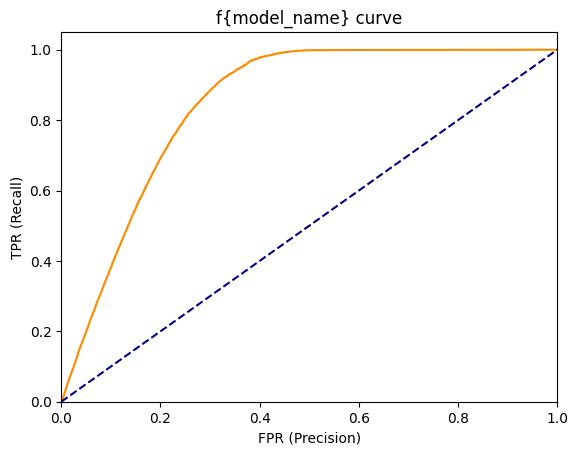

DecisionTreeClassifier result: 
              precision    recall  f1-score   support

           0       0.91      0.86      0.88    100342
           1       0.28      0.41      0.33     13910

    accuracy                           0.80    114252
   macro avg       0.60      0.63      0.61    114252
weighted avg       0.84      0.80      0.82    114252

AUC-ROC score is 0.6313846988375242


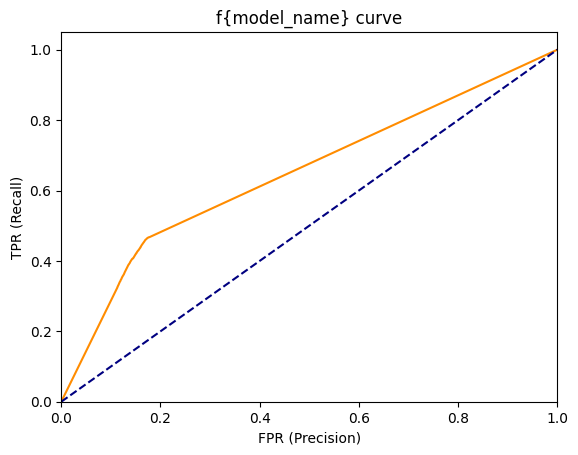

RandomForestClassifier result: 
              precision    recall  f1-score   support

           0       0.92      0.84      0.88    100342
           1       0.29      0.47      0.36     13910

    accuracy                           0.80    114252
   macro avg       0.61      0.65      0.62    114252
weighted avg       0.84      0.80      0.82    114252

AUC-ROC score is 0.6548671430121636


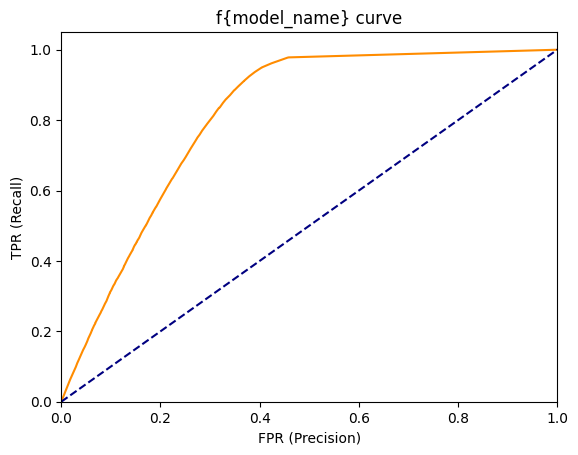

XGBClassifier result: 
              precision    recall  f1-score   support

           0       0.95      0.79      0.86    100342
           1       0.32      0.73      0.44     13910

    accuracy                           0.78    114252
   macro avg       0.64      0.76      0.65    114252
weighted avg       0.88      0.78      0.81    114252

AUC-ROC score is 0.7567758474500315


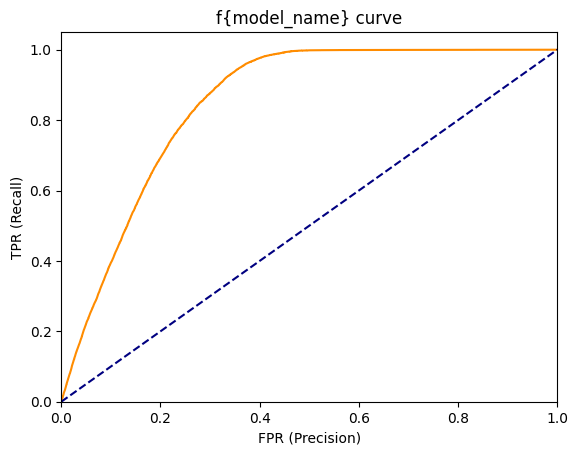

KNeighborsClassifier result: 
              precision    recall  f1-score   support

           0       0.93      0.80      0.86    100342
           1       0.28      0.58      0.38     13910

    accuracy                           0.77    114252
   macro avg       0.61      0.69      0.62    114252
weighted avg       0.85      0.77      0.80    114252

AUC-ROC score is 0.688109994516095


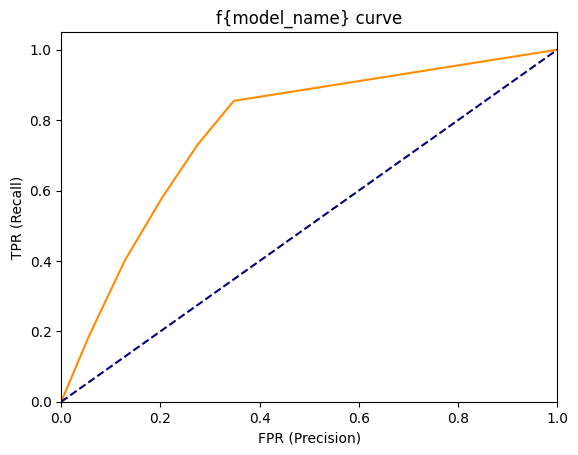

GaussianNB result: 
              precision    recall  f1-score   support

           0       0.97      0.70      0.82    100342
           1       0.28      0.85      0.43     13910

    accuracy                           0.72    114252
   macro avg       0.63      0.78      0.62    114252
weighted avg       0.89      0.72      0.77    114252

AUC-ROC score is 0.7777696353238279


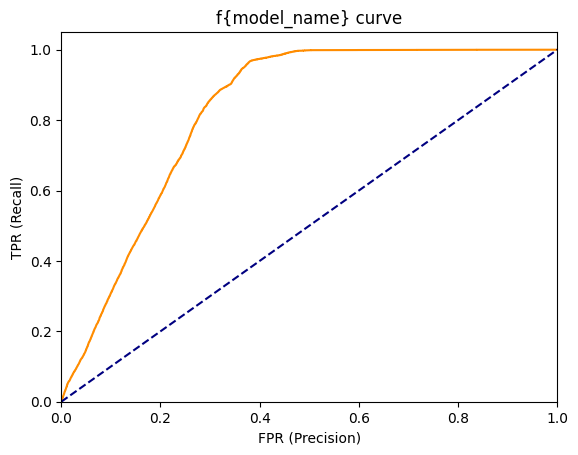

GradientBoostingClassifier result: 
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    100342
           1       0.28      0.92      0.43     13910

    accuracy                           0.71    114252
   macro avg       0.63      0.80      0.62    114252
weighted avg       0.90      0.71      0.76    114252

AUC-ROC score is 0.7963465881265511


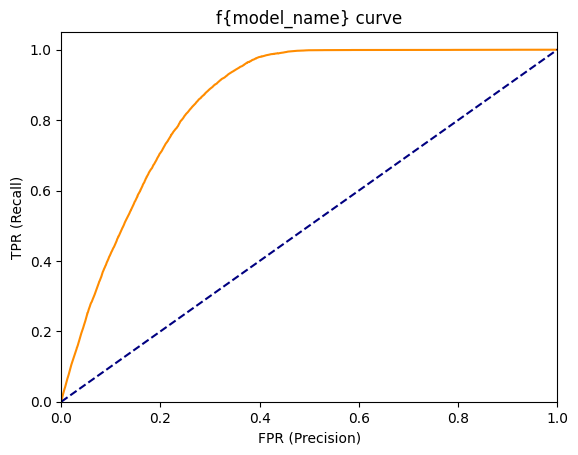

In [67]:
# Define the list of models need to compare
model_lst = [LogisticRegression(random_state=42),DecisionTreeClassifier(random_state=42),\
             RandomForestClassifier(random_state=42),XGBClassifier(random_state=42),\
            KNeighborsClassifier(),GaussianNB(),GradientBoostingClassifier()]
for i in model_lst:
    print(f'{type(i).__name__} result: ')
    y_score,report,score = model_result(i)
    print(report)
    print(f'AUC-ROC score is {score}')
    roc_auc_plot(i)

By comparing with different models, we find the GradientBoostingClassifier has the best performance. It has the higest recall ratio, which is we are more focusing on, becasue we want to do predict the customers who are willing to purchase a vehicle insurance. Meanwhile, it has the best AUC-ROC curve as well.

### Feature Selection

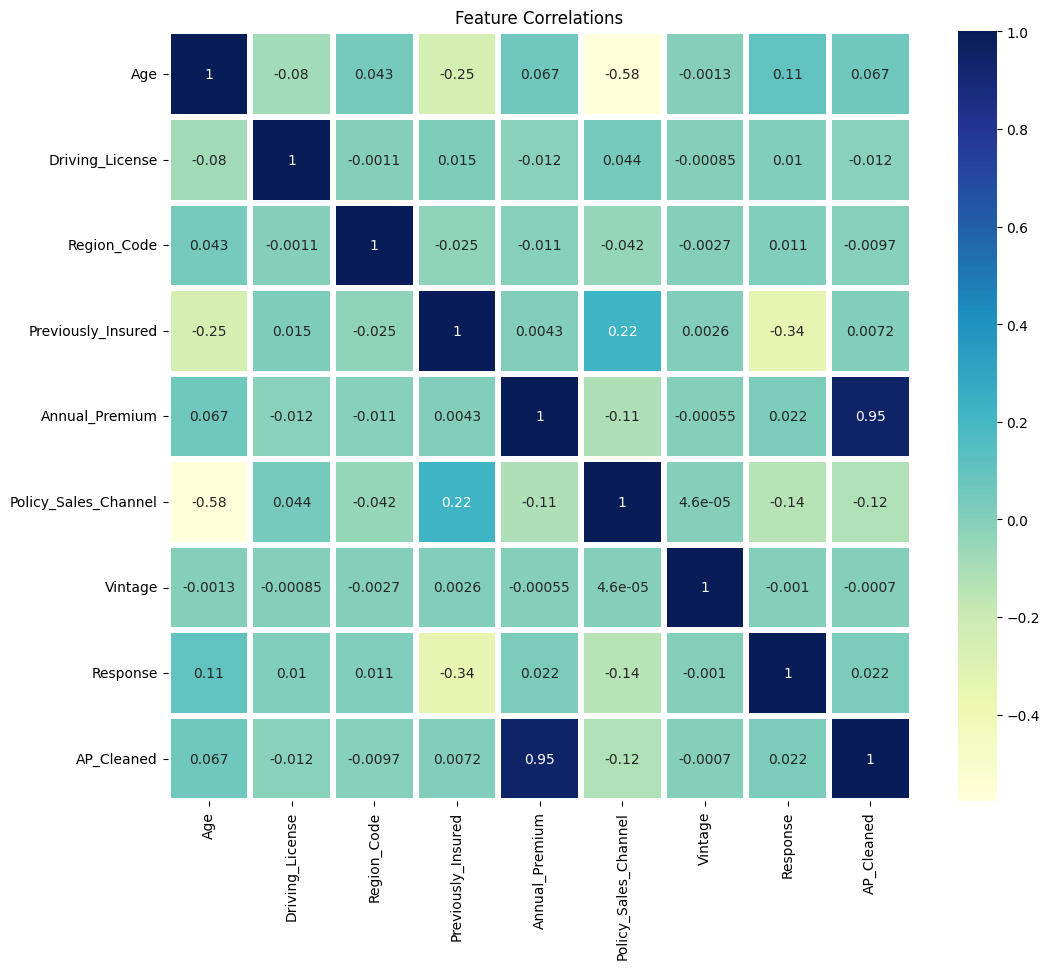

In [68]:
# Plot heatmap to get the general idea about the correlations
plt.figure(figsize = (12,10))
sns.heatmap(df.corr(),linewidth = 3, annot = True, cmap="YlGnBu")
plt.title('Feature Correlations');

In [69]:
# We can see that if two features are highly correlated,
# we will eliminate one of them because they tend to overfit the data
# It seams that some features have highly related with the target label
# need to do the feature selection later

In [70]:
# Window to the pipe to get the transformed values and column names
X_train_transformed = final_pipe[0].transform(X_train) # get the transformed values
feature_names = preprocessor.get_feature_names_out() # get column names

# Convert into a DataFrame with column names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_train_transformed_df.shape
# X_train_transformed_df.head()

(266588, 25)

In [71]:
X_train_transformed_df

,scale__AP_Cleaned,scale__Age,remainder__Gender_Male,remainder__Vehicle_Damage_Yes,remainder__Region_Code_Region_11.0,remainder__Region_Code_Region_15.0,remainder__Region_Code_Region_28.0,remainder__Region_Code_Region_29.0,remainder__Region_Code_Region_3.0,remainder__Region_Code_Region_30.0,...,remainder__Region_Code_Region_8.0,remainder__Previously_Insured_1,remainder__Vehicle_Age_< 1 Year,remainder__Vehicle_Age_> 2 Years,remainder__Policy_Sales_Channel_Channel_124.0,remainder__Policy_Sales_Channel_Channel_152.0,remainder__Policy_Sales_Channel_Channel_156.0,remainder__Policy_Sales_Channel_Channel_160.0,remainder__Policy_Sales_Channel_Channel_26.0,remainder__Policy_Sales_Channel_Others
0,0.635010,0.507692,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.407115,0.476923,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.514725,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.353783,0.400000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.630769,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266583,0.644901,0.292308,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
266584,0.507198,0.030769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
266585,0.403251,0.523077,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
266586,0.302712,0.046154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [72]:
# Apply chi-squared test for feature selection
selector = SelectKBest(score_func=chi2, k='all')
X_chi = selector.fit_transform(X_train_transformed_df, y_train)
selector.scores_

array([1.90387077e+01, 6.53166581e+02, 3.34481925e+02, 1.65555604e+04,
       2.65845255e+00, 2.35928869e+02, 2.88894976e+03, 3.05145946e-02,
       2.18668909e+00, 1.94571159e+02, 2.53778946e+01, 9.12849497e+01,
       1.02387747e-01, 5.53432410e+01, 2.36175754e+02, 1.53377959e+02,
       1.68612370e+04, 6.68019480e+03, 2.95373229e+03, 2.07236147e+03,
       7.78165135e+03, 6.47874798e+02, 1.44117491e+03, 3.11811493e+03,
       6.96727443e+02])

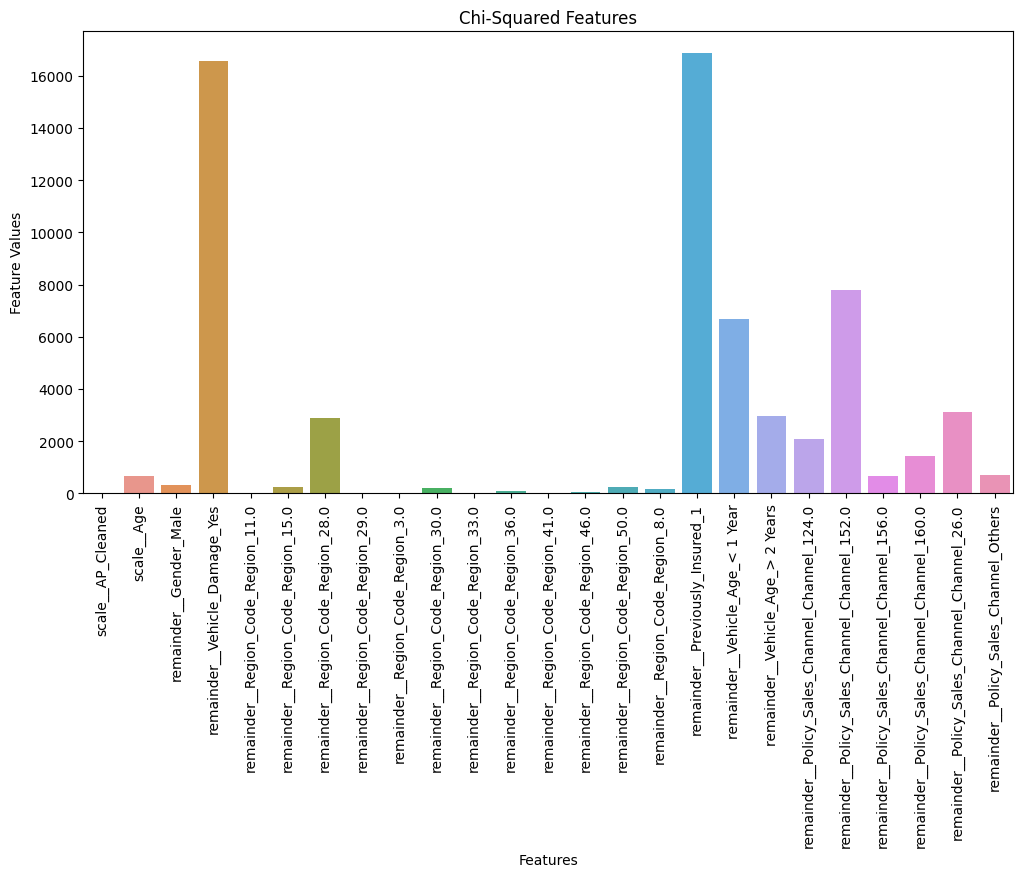

In [73]:
# Plot the results to visualize
plt.figure(figsize=(12,6))
sns.barplot(x = feature_names, y = selector.scores_)
plt.xticks(rotation=90)
plt.title('Chi-Squared Features')
plt.xlabel('Features')
plt.ylabel('Feature Values'); 

Some features look to be much stronger than any other feature. Consider top features which are significate important

In [74]:
# Select the top 18 featurs which are visiable in the plot above
temp_df = pd.Series(selector.scores_,index=feature_names)
selected_features = temp_df.sort_values(ascending=False).head(18).index

In [75]:
selected_features

Index(['remainder__Previously_Insured_1', 'remainder__Vehicle_Damage_Yes',
       'remainder__Policy_Sales_Channel_Channel_152.0',
       'remainder__Vehicle_Age_< 1 Year',
       'remainder__Policy_Sales_Channel_Channel_26.0',
       'remainder__Vehicle_Age_> 2 Years',
       'remainder__Region_Code_Region_28.0',
       'remainder__Policy_Sales_Channel_Channel_124.0',
       'remainder__Policy_Sales_Channel_Channel_160.0',
       'remainder__Policy_Sales_Channel_Others', 'scale__Age',
       'remainder__Policy_Sales_Channel_Channel_156.0',
       'remainder__Gender_Male', 'remainder__Region_Code_Region_50.0',
       'remainder__Region_Code_Region_15.0',
       'remainder__Region_Code_Region_30.0',
       'remainder__Region_Code_Region_8.0',
       'remainder__Region_Code_Region_36.0'],
      dtype='object')

In [76]:
# Re-define the dataset after feature selection
X_train_selected = X_train_transformed_df[selected_features]
X_test_transformed = final_pipe[0].transform(X_test) # get the transformed values
# Convert into a DataFrame with column names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_selected = X_test_transformed_df[selected_features]

In [77]:
X_train_selected.shape,X_test_selected.shape

((266588, 18), (114252, 18))

In [78]:
# Re-train the model to see the results
smt = SMOTE(random_state=42)
X_train_selected,y_train_selected = smt.fit_resample(X_train_selected,y_train)

In [79]:
for i in model_lst:
    model = i
    model.fit(X_train_selected,y_train_selected)
    y_p = model.predict(X_test_selected)
    print(f'{model} result:')
    print(classification_report(y_test,y_p))
    print(f'AUC-ROC score is {roc_auc_score(y_test,y_p)}\n')

LogisticRegression(random_state=42) result:
              precision    recall  f1-score   support

           0       0.99      0.64      0.77    100342
           1       0.27      0.95      0.42     13910

    accuracy                           0.67    114252
   macro avg       0.63      0.79      0.59    114252
weighted avg       0.90      0.67      0.73    114252

AUC-ROC score is 0.7930556253902094

DecisionTreeClassifier(random_state=42) result:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83    100342
           1       0.29      0.82      0.43     13910

    accuracy                           0.73    114252
   macro avg       0.63      0.77      0.63    114252
weighted avg       0.89      0.73      0.78    114252

AUC-ROC score is 0.773022824126964

RandomForestClassifier(random_state=42) result:
              precision    recall  f1-score   support

           0       0.97      0.72      0.82    100342
           1       0.29 

ValueError: feature_names must be string, and may not contain [, ] or <

We just choose the top 26 features that are clearly visible in the bar chart. We can see the results getting better especially for DecisionTree, RandomForest and XGBoost, however, considering the GradienBoosingClassifier gives us the best result. However,GradientBoostingClassifier, XGBooster,LogisticRegression have the best top three scores among the those models.

In [254]:
X_train_resampled, y_train_resampled = smt.fit_resample(X_train_transformed_df, y_train)

In [255]:
from sklearn.feature_selection import RFE
rfe = RFE(LogisticRegression(),n_features_to_select=10).fit(X_train_resampled,y_train_resampled)

In [256]:
ranking = rfe.ranking_
ranking

array([20, 17,  2,  3,  1,  4, 10,  5,  7, 25, 14, 18, 19, 11,  9, 16, 12,
        1,  8,  1,  1, 24, 23,  1, 21,  1, 13, 22,  1,  1,  1,  1, 15,  6])

In [261]:
rfe_features = X_train_resampled.columns[ranking == 1]

xgb_rfe = GradientBoostingClassifier().fit(X_train_resampled[list(rfe_features)],y_train_resampled)
print(classification_report(y_test,xgb_rfe.predict(X_test_transformed_df[list(rfe_features)])))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76    100342
           1       0.26      0.97      0.41     13910

    accuracy                           0.66    114252
   macro avg       0.63      0.79      0.59    114252
weighted avg       0.90      0.66      0.72    114252



In [262]:
print(roc_auc_score(y_test,xgb_rfe.predict(X_test_transformed_df[list(rfe_features)])))

0.7933599949423868


From the plots we can see different from LogisticRegression, this time the Previously insured plays a more important weight for predicting

### Hyperparameter Tunning

From above we get the best model is GradienBoosingClassifier , however the XGBooster has the quite similar results, so we prefer do the tunning for these top two models with the best feature selection. However, since different number of features could give us diffferent highest score for different models. So we need to tunning in different scenarios.


In [182]:
# hyperparameter tuning with XGBoostern with all the features
parameters = {
    'xgb__n_estimators': [5,10,30],
    'xgb__max_leaves': [1, 5, 7],
    'xgb__max_depth': [3,5,7]
}

xgb_classifier = XGBClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(xgb_classifier, parameters, cv=kf, scoring=['f1', 'roc_auc'], verbose=2, n_jobs=-1, refit='roc_auc')

gs.fit(X_train_selected,y_train_selected)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[19:56:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.



GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'xgb__max_depth': [3, 5, 7],
                         'xgb__max_leaves': [1, 5, 7],
                         'xgb__n_estimators': [5, 10, 30]},
             refit='roc_auc', scoring=['f1', 'roc_auc'], verbose=2)

[19:39:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=5; total time=  58.9s
[19:40:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=30; total time=  58.1s
[19:41:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=5, xgb__n_estimators=10; total time=  57.5s
[19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/pyth

[19:39:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=10; total time=  59.0s
[19:40:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=30; total time=  57.7s
[19:41:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=5, xgb__n_estimators=5; total time=  56.7s
[19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/pyth

[19:39:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=5; total time=  59.2s
[19:40:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=30; total time=  58.4s
[19:41:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=5, xgb__n_estimators=10; total time=  56.9s
[19:42:28] WARNING: /Users/runner/work/xgboost/xgboost/pyth

[19:39:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=5; total time=  58.1s
[19:40:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=1, xgb__n_estimators=10; total time=  58.2s
[19:41:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__max_depth", "xgb__max_leaves", "xgb__n_estimators" } are not used.

[CV] END xgb__max_depth=3, xgb__max_leaves=5, xgb__n_estimators=5; total time=  57.6s
[19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/pytho

In [183]:
gs.best_params_

{'xgb__max_depth': 3, 'xgb__max_leaves': 1, 'xgb__n_estimators': 5}

In [184]:
# Train XGBoost with best params_
xgb = XGBClassifier(n_estimators = 5,max_depth = 3,max_leaves = 1)
xgb.fit(X_train_selected,y_train_selected)
y_p = xgb.predict(X_test_selected)
print(classification_report(y_test,y_p))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_p)}\n')

              precision    recall  f1-score   support

           0       0.99      0.61      0.76    100342
           1       0.26      0.97      0.41     13910

    accuracy                           0.66    114252
   macro avg       0.63      0.79      0.58    114252
weighted avg       0.90      0.66      0.72    114252

AUC-ROC score is 0.7923158248108508



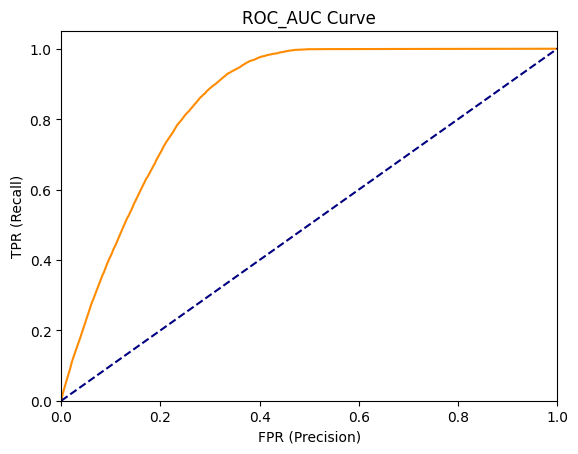

In [185]:
plt.title('ROC_AUC Curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')   
y_score = gs.predict_proba(X_test_selected)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score) 
plt.plot(fpr,tpr,color='darkorange')
plt.plot((0,1), ls='dashed',color='navy')
plt.xlim([0.0, 1.0]) # set starts from origin
plt.ylim([0.0, 1.05]);# set scale bigger to show all the graph

### Model Stacking

In [220]:
# Stacking is an ensemble learning technique to combine multiple classification models
# via a meta-classifier. Since this is a classification problem, I plan to stack some popular
# classification models as base model, then use logisticregression as the meta-classifier
# to fit based on the outputs

In [125]:
from sklearn.ensemble import StackingClassifier

In [228]:
# try to use the tunned best parameter model as base mode
estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('lr',LogisticRegression(C=0.1,class_weight=None,max_iter=50,penalty = 'l1',solver='liblinear',random_state=42)),
    ('xgb',XGBClassifier(n_estimators = 10,max_depth = 5,max_leaves = 1,random_state=42))]

sm = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=42))

sm.fit(X_train_selected,y_train_selected)

y_p = sm.predict(X_test_selected)
print(classification_report(y_test,y_p))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_p)}\n')

              precision    recall  f1-score   support

           0       0.97      0.73      0.83    100342
           1       0.30      0.82      0.43     13910

    accuracy                           0.74    114252
   macro avg       0.63      0.78      0.63    114252
weighted avg       0.89      0.74      0.78    114252

AUC-ROC score is 0.7752516988592042



In [226]:
# Try use different base model to compare the results
estimators = [
    ('nb',GaussianNB()),
    ('dt', DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_leaf=1,min_samples_split=2,random_state=42)),
    ('lr', LogisticRegression(C=0.1,class_weight=None,max_iter=50,penalty = 'l1',solver='liblinear',random_state=42)),
    ('rf',RandomForestClassifier()),
    ('xgb',XGBClassifier(n_estimators = 10,max_depth = 5,max_leaves = 1,random_state=42))]

sm = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

sm.fit(X_train_selected,y_train_selected)

y_p = sm.predict(X_test_selected)
print(classification_report(y_test,y_p))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_p)}\n')

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    100342
           1       0.29      0.83      0.43     13910

    accuracy                           0.73    114252
   macro avg       0.63      0.78      0.63    114252
weighted avg       0.89      0.73      0.78    114252

AUC-ROC score is 0.7751798862269185



In [229]:
# From the above we can see the stacked model provides a better score than some single model,
# and the auc-roc scores are around 0.77
# However, it seams that the single model XGBoost, LogisticRegression and DecisionTree have the better results.

### Deep Learning

In [391]:
# Use MLPClassifier from scikit-learn for classification problem
# Test on the feature selected dataset
nn = MLPClassifier((20, 20, 20), activation='relu')

nn.fit(X_train_selected,y_train_selected)

y_p_dl = nn.predict(X_test_selected)
print(classification_report(y_test,y_p_dl))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_p_dl)}')

              precision    recall  f1-score   support

           0       0.98      0.67      0.80    100342
           1       0.28      0.92      0.43     13910

    accuracy                           0.70    114252
   macro avg       0.63      0.80      0.61    114252
weighted avg       0.90      0.70      0.75    114252

AUC-ROC score is 0.7978984518525365


In [434]:
# First try all features
# Create Keras Model with 2 hidden layers, 100 neurons for each hidden layer
# activation = 'relu',activation = 'sigmoid'

# balanced the dataset
smt = SMOTE(random_state=42)
X_train_dl,y_train_dl = smt.fit_resample(X_train_transformed_df,y_train)

model_dl = Sequential()
model_dl.add(Dense(30, input_dim=17, activation='relu'))
model_dl.add(keras.layers.Dropout(0.5)) # reduce overfitting
model_dl.add(Dense(30, activation='relu'))
model_dl.add(keras.layers.Dropout(0.5))
model_dl.add(Dense(30, activation='relu'))
model_dl.add(keras.layers.Dropout(0.5)) # reduce overfitting
model_dl.add(Dense(1, activation='sigmoid'))

# Compile model             
model_dl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_dl.fit(X_train_dl, y_train_dl, epochs=20,validation_data=(X_test_transformed_df, y_test))

Epoch 1/20
14614/14614 [==============================] - 9s 587us/step - loss: 0.4546 - accuracy: 0.7807 - val_loss: 0.4760 - val_accuracy: 0.6873
Epoch 2/20
14614/14614 [==============================] - 8s 553us/step - loss: 0.4420 - accuracy: 0.7885 - val_loss: 0.4895 - val_accuracy: 0.6821
Epoch 3/20
14614/14614 [==============================] - 8s 533us/step - loss: 0.4412 - accuracy: 0.7897 - val_loss: 0.4717 - val_accuracy: 0.6940
Epoch 4/20
14614/14614 [==============================] - 8s 575us/step - loss: 0.4402 - accuracy: 0.7894 - val_loss: 0.4773 - val_accuracy: 0.6991
Epoch 5/20
14614/14614 [==============================] - 8s 537us/step - loss: 0.4395 - accuracy: 0.7904 - val_loss: 0.4834 - val_accuracy: 0.6697
Epoch 6/20
14614/14614 [==============================] - 8s 541us/step - loss: 0.4397 - accuracy: 0.7901 - val_loss: 0.4940 - val_accuracy: 0.6939
Epoch 7/20
14614/14614 [==============================] - 8s 548us/step - loss: 0.4388 - accuracy: 0.7907 - val_

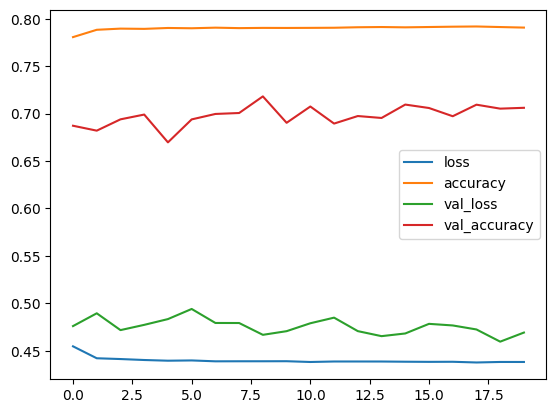

In [435]:
pd.DataFrame(history.history).plot();

In [436]:
y_p_dl = model_dl.predict(X_test_transformed_df)
y_pred_dl = np.round(y_p_dl)
print(classification_report(y_test,y_pred_dl))
print(f'AUC-ROC score is {roc_auc_score(y_test,y_pred_dl)}')

3571/3571 [==============================] - 1s 232us/step
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    100342
           1       0.28      0.92      0.43     13910

    accuracy                           0.71    114252
   macro avg       0.63      0.80      0.62    114252
weighted avg       0.90      0.71      0.76    114252

AUC-ROC score is 0.7972391745894032


In [437]:
# We find these two deep learning models give quite similar results compared with previous models
# We don't get much imporved scores after using deeep learning model

### Model Interpretation

In [438]:
# Create Permutation importance for the deep learning model to make it more visibale
# It will shuffle the values in a single column, make predictions using the dataset.
# Use these predictions and the true target values to calculate the loss.
# That performance deterioration measures the importance of the variable.
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(nn, random_state=42)

perm.fit(X_train_selected, y_train_selected)

eli5.show_weights(perm, feature_names=X_train_selected.columns.tolist())

Weight,Feature
0.0858 ± 0.0005,remainder__Previously_Insured_1
0.0671 ± 0.0005,remainder__35-50_ages
0.0547 ± 0.0011,remainder__Vehicle_Damage_No
0.0368 ± 0.0010,target__Policy_Sales_Channel
0.0324 ± 0.0004,remainder__50-65_ages
0.0228 ± 0.0003,remainder__20-35_ages
0.0081 ± 0.0003,remainder__Vehicle_Damage_Yes
0.0065 ± 0.0004,target__Region_Code
0.0056 ± 0.0002,remainder__65-80_ages
0.0045 ± 0.0002,remainder__Gender_Male


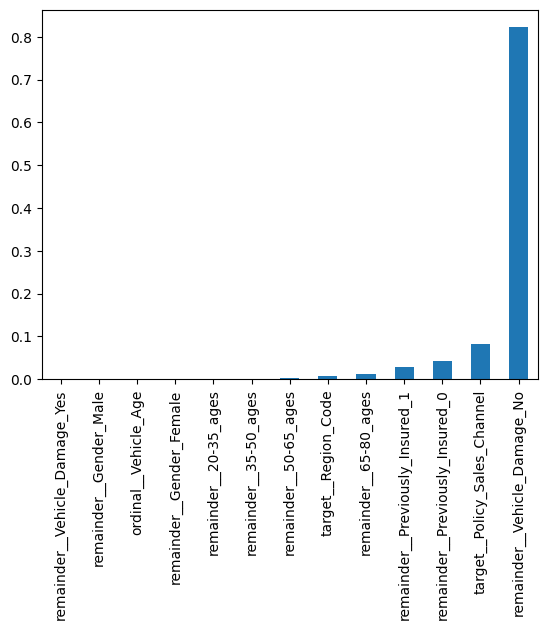

In [461]:
## get prepare the train set for decissiontree regressor under the surrogate model
dt_mi = DecisionTreeRegressor()

# Get predicted probabilities
# Get second column because it's the 1's label
dt_mi.fit(X_train_selected,xgb.predict_proba(X_train_selected)[:,1])

#plot the surrogate model
pd.Series(dt_mi.feature_importances_, index=X_train_selected.columns).sort_values().plot(kind='bar');

In [462]:
# We can see for the XGBoost model, the not damaged vehicle contributes the most weight
# of predicting the model. However, it still left some features are not clearly visiable to us
# means they are little affact the model accuracy. 
# In terms of we could do more feature selection based on specific model later.

### Conclusion

Based on the provided data, after doing all the data cleaning and feature engineering, it seams that a simple Logistic Regression or XGBoost is the best model with the best performance.

Due to the high correlation, we dropped some features and keep the rest features which could significately increase the model performance. However, we do the model interpretation to show that some specific model maybe need furture feature engineering to achieve even a better result, for example XGBoost.

Overall, we have relevant large amounts of data, probably the data are not quite enough to predict a customer will purchase an insurance or not. However, it is kind of goog to achieve a recall of 93% and a ROC AUC nearly 0.8. 